In [1]:
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
import json
from pprint import pprint
from sqlalchemy import create_engine
# Google developer API Key
from config import gkey

In [2]:
health_inspection_df = pd.read_csv("~/Downloads/Food_Inspections.csv")
health_inspection_df

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location
0,2386126,JACK 'S HOT DOG,JACK 'S HOT DOG,59290,Restaurant,Risk 1 (High),3577 W ARMITAGE AVE,CHICAGO,IL,60647,08/17/2020,Canvass Re-Inspection,Pass,NaN,41.917176,-87.716543,"(-87.71654336353762, 41.917175505691226)"
1,2386119,DAN'S HOT DOG STAND,DAN'S HOT DOG STAND,84306,Restaurant,Risk 2 (Medium),9314 S ASHLAND AVE,CHICAGO,IL,60620,08/14/2020,Canvass,Fail,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,41.724354,-87.662901,"(-87.66290116466614, 41.72435389621999)"
2,2370161,7-ELEVEN,7-ELEVEN,1474087,Grocery Store,Risk 2 (Medium),4346 N KIMBALL AVE,CHICAGO,IL,60618,05/06/2020,Canvass Re-Inspection,Fail,"1. PERSON IN CHARGE PRESENT, DEMONSTRATES KNOW...",41.960731,-87.713276,"(-87.71327613356749, 41.960731356474305)"
3,2365779,DOG HAUS,DOG HAUS,2536489,Restaurant,Risk 1 (High),2464-2466 N LINCOLN AVE,CHICAGO,IL,60614,03/13/2020,Canvass,Fail,21. PROPER HOT HOLDING TEMPERATURES - Comments...,41.926745,-87.650790,"(-87.65078998020067, 41.92674471870681)"
4,2282763,SAJJAD INC,MANGI'S,20717,Restaurant,Risk 1 (High),3801 N LINCOLN AVE,CHICAGO,IL,60613,04/08/2019,Canvass,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.950636,-87.676145,"(-87.67614471625586, 41.95063604438053)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1414,197301,MILLENNIUM DOGS,MILLENNIUM DOGS,1953329,Restaurant,Risk 1 (High),151 E Randolph ST,CHICAGO,IL,60601,02/26/2010,Canvass,Pass,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.884167,-87.622603,"(-87.6226033725251, 41.88416745447802)"
1415,176298,WINDY CITY HOT DOGS INC,WINDY CITY HOT DOGS INC,1245171,Restaurant,Risk 1 (High),4205 W 63RD ST,CHICAGO,IL,60629,02/18/2010,Canvass,Pass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.778486,-87.727886,"(-87.72788606162167, 41.77848613692535)"
1416,74369,ILLINOIS SPORTSERVICE INC.,HOT DOG VIENNA BEEF 14 (#512),14616,KIOSK,Risk 2 (Medium),333 W 35TH ST,CHICAGO,IL,60616,04/02/2010,Canvass,Pass,NaN,41.830784,-87.635296,"(-87.6352957830455, 41.83078366228312)"
1417,160212,MR. GYROS INC,MR. GYROS INC,1619550,Restaurant,Risk 1 (High),107 W DIVISION ST,CHICAGO,IL,60610,01/06/2010,Short Form Complaint,Fail,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,41.903785,-87.631800,"(-87.63179996351542, 41.90378484203853)"


In [11]:
# Google API
# geocoordinates
target_coordinates = "41.882702, -87.619392" #chicago coordinates
target_search = "hot dogs" #This will return restaurants that offer these types of food
target_radius = 10000
target_type = "restaurant"

# set up a parameters dictionary
params = {
    "location": target_coordinates,
    "keyword": target_search,
    "radius": target_radius,
    "type": target_type,
    "key": gkey
}
# base url
base_url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"
# run a request using our params dictionary
response = requests.get(base_url, params=params)
places_data = response.json()
places_data

{'html_attributions': [],
 'next_page_token': 'Aap_uEAD_LmUQ-1383RMIlWs6o9J5tzssV6MWH6sF6YWSkEimp3Nla3u5ADrFgvjNYb6dokm8TV33GsAKLYTPiU6w8NLe_IntZSx7PXwY2Xq66cwGHlJX4wcWVOX6tkWnj1ja8nqXb3hseyTdtvy-wqENFUuxQAZtYuslZoIVgWYk_WMK0LfW02umaZBNFmXjHXAMPo0iHK8rWATJFeuEHrNRLoIoz5WXRJ5pc99FkIpy5Q4CIZ0FfsNplBOmU82vrar57tXQXaxqkcYSk3lHqSfakHdoU8Rz0n2CWUnKXwBYTZfW5cHTl-JonPZsyi_nt8MiIYxTAwSaYIBHssRxpXTgt1zgKqWPLOR-Z10n0L8ycBtFH_LjdBpaGVqGNOnTRZpkxgMQqt_Xt19Z4EPNU4p7VHZKNHvLCHbrJNYf0XIeYKB9g16xu3giG3gymf2wX0pIB3n7R5d3w',
 'results': [{'business_status': 'OPERATIONAL',
   'geometry': {'location': {'lat': 41.89349, 'lng': -87.667403},
    'viewport': {'northeast': {'lat': 41.89483982989272,
      'lng': -87.66605317010726},
     'southwest': {'lat': 41.89214017010728, 'lng': -87.66875282989271}}},
   'icon': 'https://maps.gstatic.com/mapfiles/place_api/icons/v1/png_71/restaurant-71.png',
   'icon_background_color': '#FF9E67',
   'icon_mask_base_uri': 'https://maps.gstatic.com/mapfiles/place_api/icons/v

In [12]:
results = []
for result in places_data["results"]:
    results.append({"name": result["name"], "vicinity": result["vicinity"], "rating": result["rating"], "business_status": result["business_status"]})
google_results_df = pd.DataFrame(results)
google_results_df

,name,vicinity,rating,business_status
0,Duk's Red HOTS,"636 N Ashland Ave, Chicago",4.4,OPERATIONAL
1,Devil Dawgs Rush St,"804 N Rush St, Chicago",4.9,OPERATIONAL
2,Fatso's Last Stand,"1982 N Clybourn Ave, Chicago",4.3,OPERATIONAL
3,Relish Chicago Hot Dogs,"315 S Michigan Ave, Chicago",4.5,OPERATIONAL
4,Dog House Grill,"1534 N Wells St, Chicago",3.9,OPERATIONAL
5,Portillo's Hot Dogs,"100 W Ontario St, Chicago",4.4,OPERATIONAL
6,Mister J's,"822 N State St, Chicago",4.1,OPERATIONAL
7,Fatso's Last Stand,"2258 W Chicago Ave, Chicago",4.4,OPERATIONAL
8,Devil Dawgs on State,"767 S State St, Chicago",4.4,OPERATIONAL
9,George's Hot Dogs,"1876 N Damen Ave, Chicago",4.4,OPERATIONAL


In [13]:
# Get the remaining 2 pages of results from the google api and add to existing results
for i in range(0,2):
    time.sleep(2)
    params['pagetoken'] = places_data['next_page_token']
    response = requests.get(base_url, params=params)
    places_data = response.json()
    places_data

    results = []
    for result in places_data["results"]:
        results.append({"name": result["name"], "vicinity": result["vicinity"], "rating": result["rating"], "business_status": result["business_status"]})
    google_results_df = pd.concat([google_results_df, pd.DataFrame(results)])


google_results_df

,name,vicinity,rating,business_status
0,Duk's Red HOTS,"636 N Ashland Ave, Chicago",4.4,OPERATIONAL
1,Devil Dawgs Rush St,"804 N Rush St, Chicago",4.9,OPERATIONAL
2,Fatso's Last Stand,"1982 N Clybourn Ave, Chicago",4.3,OPERATIONAL
3,Relish Chicago Hot Dogs,"315 S Michigan Ave, Chicago",4.5,OPERATIONAL
4,Dog House Grill,"1534 N Wells St, Chicago",3.9,OPERATIONAL
5,Portillo's Hot Dogs,"100 W Ontario St, Chicago",4.4,OPERATIONAL
6,Mister J's,"822 N State St, Chicago",4.1,OPERATIONAL
7,Fatso's Last Stand,"2258 W Chicago Ave, Chicago",4.4,OPERATIONAL
8,Devil Dawgs on State,"767 S State St, Chicago",4.4,OPERATIONAL
9,George's Hot Dogs,"1876 N Damen Ave, Chicago",4.4,OPERATIONAL


In [19]:

# base url
def search_google(params):
    base_url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"
    # run a request using our params dictionary
    response = requests.get(base_url, params=params)
    places_data = response.json()

    results = []
    for result in places_data["results"]:
        results.append({"name": result["name"], "vicinity": result["vicinity"], "rating": result["rating"], "business_status": result["business_status"]})
    results_df = pd.DataFrame(results)

    for i in range(0,2):
        time.sleep(2)
        params['pagetoken'] = places_data['next_page_token']
        response = requests.get(base_url, params=params)
        places_data = response.json()
        places_data

        results = []
        for result in places_data["results"]:
            results.append({"name": result["name"], "vicinity": result["vicinity"], "rating": result["rating"], "business_status": result["business_status"]})
        results_df = pd.concat([results_df, pd.DataFrame(results)])
    return results_df



google_results_df = search_google({
    "location": "41.882702, -87.619392",
    "keyword": "hot dogs",
    "radius": 10000,
    "type": "restaurant",
    "key": gkey
})

google_results_df = pd.concat([google_results_df , search_google({
    # "location": "41.82908, -87.65083",
    "location": "41.882702, -87.619392",
    "keyword": "hamburgers",
    "radius": 10000,
    "type": "restaurant",
    "key": gkey
})])
google_results_df = pd.concat([google_results_df , search_google({
    "location": "41.882702, -87.619392",
    "keyword": "tacos",
    "radius": 10000,
    "type": "hamburgers",
    "key": gkey
})])

google_results_df = pd.concat([google_results_df , search_google({
    "location": "41.882702, -87.619392",
    "keyword": "pizza",
    "radius": 10000,
    "type": "hamburgers",
    "key": gkey
})])
google_results_df

,name,vicinity,rating,business_status
0,Chicago's Dog House,"816 W Fullerton Ave, Chicago",4.6,OPERATIONAL
1,Duk's Red HOTS,"636 N Ashland Ave, Chicago",4.4,OPERATIONAL
2,Devil Dawgs Rush St,"804 N Rush St, Chicago",4.9,OPERATIONAL
3,Fatso's Last Stand,"1982 N Clybourn Ave, Chicago",4.3,OPERATIONAL
4,The Wiener's Circle,"2622 N Clark St, Chicago",4.4,OPERATIONAL
...,...,...,...,...
15,Homeslice,"938 W Webster Ave, Chicago",4.5,OPERATIONAL
16,La Pizza & La Pasta at Eataly Chicago,"43 E Ohio St, Chicago",4.4,OPERATIONAL
17,Domino's Pizza,"2231 N Lincoln Ave, Chicago",3.6,OPERATIONAL
18,Kung Fu Pizza Bar,"1225 N Milwaukee Ave, Chicago",4.7,OPERATIONAL


In [20]:
# Data cleaning - reset index and remove bad data
google_results_df = google_results_df[google_results_df['vicinity'] != "Chicago"]
google_results_df = google_results_df.drop_duplicates()
google_results_df = google_results_df.reset_index(drop=True)
google_results_df

,name,vicinity,rating,business_status
0,Chicago's Dog House,"816 W Fullerton Ave, Chicago",4.6,OPERATIONAL
1,Duk's Red HOTS,"636 N Ashland Ave, Chicago",4.4,OPERATIONAL
2,Devil Dawgs Rush St,"804 N Rush St, Chicago",4.9,OPERATIONAL
3,Fatso's Last Stand,"1982 N Clybourn Ave, Chicago",4.3,OPERATIONAL
4,The Wiener's Circle,"2622 N Clark St, Chicago",4.4,OPERATIONAL
...,...,...,...,...
230,Homeslice,"938 W Webster Ave, Chicago",4.5,OPERATIONAL
231,La Pizza & La Pasta at Eataly Chicago,"43 E Ohio St, Chicago",4.4,OPERATIONAL
232,Domino's Pizza,"2231 N Lincoln Ave, Chicago",3.6,OPERATIONAL
233,Kung Fu Pizza Bar,"1225 N Milwaukee Ave, Chicago",4.7,OPERATIONAL


In [21]:
merged_dfs = []

for i in range (0, len(google_results_df)):
    address = google_results_df.loc[i, "vicinity"]
    address = address.split(",")[0].upper()
    rating = google_results_df.loc[i, "rating"]
    business_status = google_results_df.loc[i, "business_status"]

    subset_health_inspection_df = health_inspection_df.loc[health_inspection_df['Address'].str.contains(address)].reset_index(drop=True)
    subset_health_inspection_df['Rating'] = pd.Series([rating for x in range(len(subset_health_inspection_df.index))], dtype='float64')
    subset_health_inspection_df['Business Status'] = pd.Series([business_status for x in range(len(subset_health_inspection_df.index))], dtype='str')

    if len(subset_health_inspection_df) > 0:
        merged_dfs.append(subset_health_inspection_df)


merged_df = pd.concat(merged_dfs).reset_index(drop=True)
merged_df

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location,Rating,Business Status
0,1948615,DUKS RED HOTS,DUKS RED HOTS,69637,Restaurant,Risk 2 (Medium),636 N ASHLAND AVE,CHICAGO,IL,60622,08/03/2016,Complaint,Fail,2. FACILITIES TO MAINTAIN PROPER TEMPERATURE -...,41.893513,-87.667363,"(-87.66736304901177, 41.89351341598553)",4.4,OPERATIONAL
1,1566932,DUKS RED HOTS,DUKS RED HOTS,69637,Restaurant,Risk 2 (Medium),636 N ASHLAND AVE,CHICAGO,IL,60622,08/31/2015,Canvass,Pass w/ Conditions,2. FACILITIES TO MAINTAIN PROPER TEMPERATURE -...,41.893513,-87.667363,"(-87.66736304901177, 41.89351341598553)",4.4,OPERATIONAL
2,250451,DUKS RED HOTS,DUKS RED HOTS,69637,Restaurant,Risk 2 (Medium),636 N ASHLAND AVE,CHICAGO,IL,60622,06/01/2010,Complaint Re-Inspection,Fail,2. FACILITIES TO MAINTAIN PROPER TEMPERATURE -...,41.893513,-87.667363,"(-87.66736304901177, 41.89351341598553)",4.4,OPERATIONAL
3,1110301,DOWNTOWN DOGS,DOWNTOWN DOGS,41329,Restaurant,Risk 1 (High),804 N RUSH ST,CHICAGO,IL,60611,02/21/2013,Canvass,Pass w/ Conditions,2. FACILITIES TO MAINTAIN PROPER TEMPERATURE -...,41.896858,-87.625829,"(-87.62582920151347, 41.896858320721826)",4.9,OPERATIONAL
4,2262088,THE WEINER'S CIRCLE,WEINER CIRCLE,2431721,Restaurant,Risk 1 (High),2622 N CLARK ST,CHICAGO,IL,60614,02/15/2019,Canvass,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.930201,-87.643761,"(-87.64376068789055, 41.930200677637416)",4.4,OPERATIONAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,1110289,SHERATON CHICAGO HOTEL/TOWERS,BANQUETS - MAIN KITCHEN,23337,Restaurant,Risk 1 (High),301 E NORTH WATER ST,CHICAGO,IL,60611,02/07/2013,Canvass,Fail,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.889458,-87.620368,"(-87.62036837642913, 41.88945828010943)",3.8,CLOSED_TEMPORARILY
256,2304125,ARCLIGHT CINEMAS,ARCLIGHT CINEMAS,2404807,Restaurant,Risk 2 (Medium),1500 N CLYBOURN AVE,CHICAGO,IL,60610,08/02/2019,Canvass,Pass w/ Conditions,2. CITY OF CHICAGO FOOD SERVICE SANITATION CER...,41.908560,-87.646453,"(-87.64645268572522, 41.90856013536843)",4.1,OPERATIONAL
257,2304176,ARCLIGHT CINEMAS,ARCLIGHT CINEMAS,2404807,Restaurant,Risk 2 (Medium),1500 N CLYBOURN AVE,CHICAGO,IL,60610,08/06/2019,Canvass Re-Inspection,Pass w/ Conditions,2. CITY OF CHICAGO FOOD SERVICE SANITATION CER...,41.908560,-87.646453,"(-87.64645268572522, 41.90856013536843)",4.1,OPERATIONAL
258,1978672,ARCLIGHT CINEMAS,ARCLIGHT CINEMAS,2404807,Restaurant,Risk 2 (Medium),1500 N CLYBOURN AVE,CHICAGO,IL,60610,12/27/2016,Short Form Complaint,Pass w/ Conditions,21. * CERTIFIED FOOD MANAGER ON SITE WHEN POTE...,41.908560,-87.646453,"(-87.64645268572522, 41.90856013536843)",4.1,OPERATIONAL


In [22]:
merged_df_subset = merged_df.loc[merged_df["Results"] == "Fail"]
# merged_df_subset = merged_df.loc[merged_df["Results"] != "Pass"]
merged_df_subset
counts = merged_df_subset.Address.value_counts()
plot_df = []
for address in pd.unique(merged_df['Address']):
    count = 0
    if address in counts.index:
        count = counts[address]

    plot_df.append({
        'address': address,
        'failed health inspections': count,
        'name': merged_df.loc[merged_df['Address'] == address]['DBA Name'].iloc[0],
        'rating': merged_df.loc[merged_df['Address'] == address]['Rating'].iloc[0],
    })
plot_df = pd.DataFrame(plot_df)
plot_df

,address,failed health inspections,name,rating
0,636 N ASHLAND AVE,2,DUKS RED HOTS,4.4
1,804 N RUSH ST,0,DOWNTOWN DOGS,4.9
2,2622 N CLARK ST,0,THE WEINER'S CIRCLE,4.4
3,1534 N WELLS ST,0,THE DOG HOUSE GRILL,3.9
4,100 W ONTARIO ST,6,PORTILLO'S HOT DOGS,4.4
5,2258 W CHICAGO AVE,0,PHIL'S LAST STAND,4.4
6,3021 N BROADWAY,0,FLUB A DUB CHUB'S,4.7
7,1876 N DAMEN AVE,2,GEORGE'S HOT DOG,4.4
8,1017 W IRVING PARK RD,0,BYRONS KITCHENS,4.5
9,1701 W LAWRENCE AVE,3,BYRONS HOT DOG INC,4.3


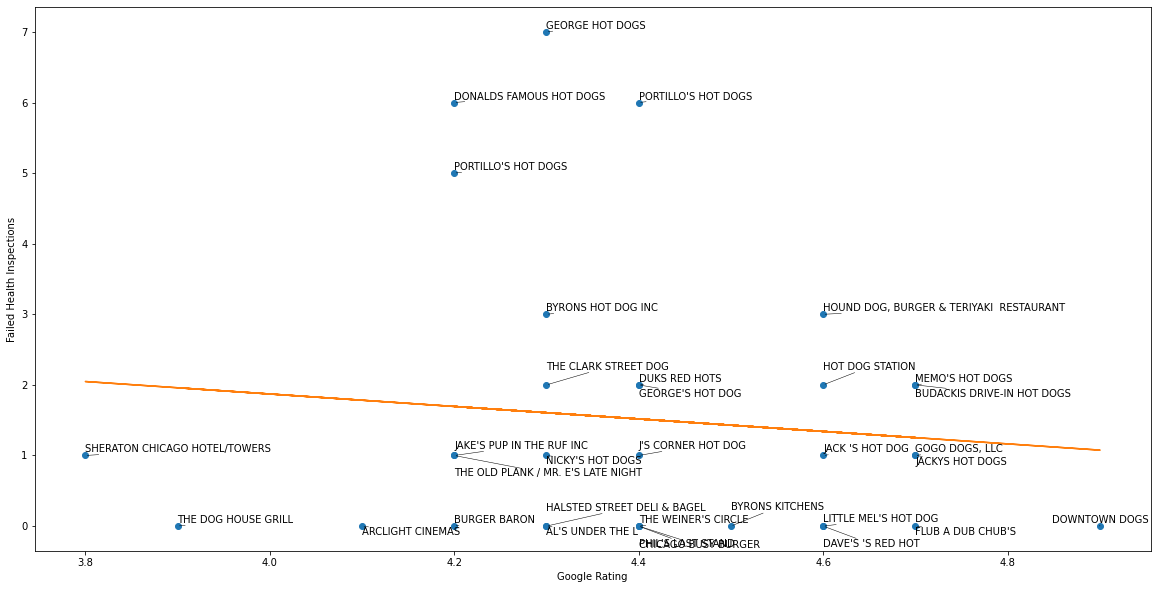

In [23]:
import matplotlib.pyplot as plt
from adjustText import adjust_text

x = plot_df['rating'].to_numpy()
y = plot_df['failed health inspections'].to_numpy()
plt.xlabel("Google Rating")
plt.ylabel("Failed Health Inspections")

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, y, 'o', x, p(x), "-")

texts = []
for row in plot_df.iterrows():
    row = row[1]
    texts.append(plt.text(row['rating'], row['failed health inspections'], row['name']))

adjust_text(
    texts,
    x=x,
    y=y,
    autoalign='y',
    ha='left',
    only_move={'points':'y', 'text':'y'},
    force_points=0.15,
    arrowprops=dict(arrowstyle="-", lw=0.5)
)
plt.rcParams["figure.figsize"] = (20,10)

plt.show()